# **Reinforecement Learning - Tic Tac Toe**


### Tabular Q-learning

---

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd ./drive/My\ Drive/RL

Mounted at /content/drive
/content/drive/My Drive/RL


In [ ]:
from TicTacToe.TicTacToe import TicTacToeState
from Players.HumanPlayer import HumanPlayer
from Players.MaxminPlayer import MaxminPlayer
from Players.QTPlayer import QTPlayer
from Players.RandomPlayer import RandomPlayer
from Utility.Auxiliary import *
%matplotlib inline

---
## **Learning**

We're going to train our tabular Q-learning player once against a random player, once against another Q-learning player, and once against previous copies of himself (self-play). Each training will show a running average of results of 100 games during the training.  

For evaluation, we'll test our player against 3 other players:
- 10,000 games against a random player.
- 1,000 games against a random minimax player, which randomly chooses between all the best actions for *k* turns ahead. We're using 1,000 since its calculation time is longer and also because it has a smaller action space (only the optimal actions).
- 2 games against himself - meaning an identical player (once starting first and once second). 2 games is enough because both players are deterministic so all games will end up the same.

We'll make ourselves a convinient evaluation function for the above, which will take advantage of the ```evaluate``` function.

In [ ]:
state = TicTacToeState()

# Evaluation function:
def multi_evaluation(state, player, opponents, nGamesList):
    N = len(opponents)
    pWin1 = [0] * N
    pWin2 = [0] * N
    pTie = [0] * N
    for i, (opp, nGames) in enumerate(zip(opponents, nGamesList)):
        pWin1[i], pWin2[i], pTie[i] = evaluate(state, player, opp, nGames)
    print()
    for i, (opp, nGames) in enumerate(zip(opponents, nGamesList)):
        print("{} vs. {}: P1 Win {:.2f}% | P2 Win {:.2f}% | Tie {:.2f}%".format(player.name, opp.name, pWin1[i] * 100,
                                                                                pWin2[i] * 100, pTie[i] * 100))

### Learning against a random player:

100%|██████████| 100000/100000 [06:53<00:00, 241.76it/s]


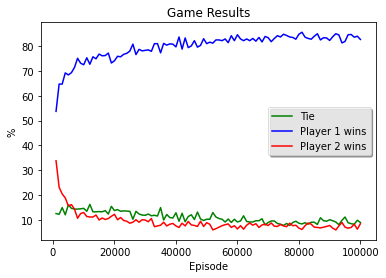

In [ ]:
policy_fileName = "./TicTacToe/Policies/Qpolicy_vsRand"
nGames = 100000

p1 = QTPlayer("QT", isLearning=True)
p2 = RandomPlayer("Random")

log = train(state, p1, p2, nGames=nGames)
plot_log(log)
p1.save_policy(policy_fileName)

We can see that our player started out with only about 50% wins but quickly began winning more and more, until reaching a point where it only loses 10% of the time and ties 10% percent of the time. On first thought we would expect our player to become perfect and never lose, but remember that we added a constant exploration rate - which means that even after learning, our player will sometimes chose a random move - which may result in a loss.  
Note that the learning curve reaches some plato around epsisode 40,000, which means that maybe we could have stopped the training then.

Now let's test our player...

In [ ]:
policy_fileName = "./TicTacToe/Policies/Qpolicy_vsRand"
p1 = QTPlayer("QT", isLearning=False)
p1.load_policy(policy_fileName)

p2 = RandomPlayer("Random")
p3 = MaxminPlayer("Minimax", max_depth=4)
p4 = QTPlayer("QT2", isLearning=False)
p4.load_policy(policy_fileName)
opponents = [p2, p3, p4]
nGamesList = [10000, 1000, 2]
multi_evaluation(state, p1, opponents, nGamesList)



QT vs. Random: P1 Win 95.20% | P2 Win 0.00% | Tie 4.80%
QT vs. Minimax: P1 Win 0.00% | P2 Win 0.00% | Tie 100.00%
QT vs. QT2: P1 Win 0.00% | P2 Win 0.00% | Tie 100.00%


Yes! The results are as expected:
- Almost all wins against the random player, no losses, and only a small amount of ties - because even a broken clock is right twice a day.
- As we know, for two perfect players a game of Tic Tac Toe always ends with a tie. So 100% ties against a perfect Minimax player is just what we want.
- Same goes for playing against himself.

### Learning against another Q-learning player:

This time we'll try training two different Q-learning players at the same time. Each of them plays and tries to maximize its results. We can think of this setting as two humans who are completely infarmiliar with the rules and strategy of the game, and just start playing against each other. At first they both just try out moves, but slowly they start learning rules and strategy and improve in the game simultaniously. The hope is that each of the players improvement will cause its opponent to try and improve even more - until they both reach some equillibrium.

100%|██████████| 200000/200000 [28:12<00:00, 118.20it/s]


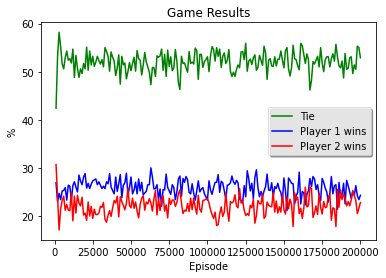

In [ ]:
policy_fileName = "./TicTacToe/Policies/Qpolicy_vsQ"
nGames = 200000

p1 = QTPlayer("QT1", isLearning=True)
p2 = QTPlayer("QT2", isLearning=True)

log = train(state, p1, p2, nGames=nGames)
plot_log(log)
p1.save_policy(policy_fileName)

We can see that training started out with about an equal amount of wins, losses, and ties. Only this time, since both of the players were learning, the amount of ties was the growing value.  
We can see that this sort of training is much less stable. This is since both players are constantly learning - so for each of them the enviroment keeps changing all the time. This causes the enviroment to be non-stationary (meaning that the state transition probabilities aren't constant). It is known that Q-learning is good for stationary enviroments, so this may be the reason for the instability of this sort of training.

Now let's test our player...

In [ ]:
policy_fileName = "./TicTacToe/Policies/Qpolicy_vsQ"
p1 = QTPlayer("QT", isLearning=False)
p1.load_policy(policy_fileName)

p2 = RandomPlayer("Random")
p3 = MaxminPlayer("Minimax", max_depth=4)
p4 = QTPlayer("QT2", isLearning=False)
p4.load_policy(policy_fileName)
opponents = [p2, p3, p4]
nGamesList = [10000, 1000, 2]
multi_evaluation(state, p1, opponents, nGamesList)



QT vs. Random: P1 Win 93.17% | P2 Win 0.20% | Tie 6.63%
QT vs. Minimax: P1 Win 0.00% | P2 Win 0.00% | Tie 100.00%
QT vs. QT2: P1 Win 0.00% | P2 Win 0.00% | Tie 100.00%


As we can see above, our player did in fact manage to achieve a good score (just a bit worse than the QT player which learned against a random player), although a random player did in fact manage to win it in a very small amount of games. This may be explained by the fact that this player learned mostly from playing against a challenging opponent, so as it may have learned moves to play well against him, actually taking random moves which seem unoptimal may confuse our player.

### Learning against himself (self-learning):

In self-learning we let the player learn against a previous copy of himself. Each 10,000 episodes the other player is updated with the learnt Q-table. We set the other player not to learn during the training process.  
In this type of training, we hope to take advantage of the fact that our player has improved, and let it play against better and better versions of players (hopefully) - so that it may manage to learn playing against advanced opponents.  
As for implementation, self-learning is implemented in the ```training``` function by inserting ```None``` player for player2.

100%|██████████| 200000/200000 [23:21<00:00, 142.66it/s]


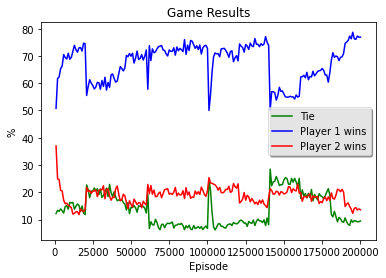

In [ ]:
policy_fileName = "./TicTacToe/Policies/Qpolicy_selfPlay"
nGames = 200000

p1 = QTPlayer("QT1", isLearning=True)

log = train(state, p1, nGames=nGames)  # p2 = None is translated to self-play
plot_log(log)
p1.save_policy(policy_fileName)

We can see that in self-play training, the learning player achieved a high percentage of wins, and managed to continue growing.  
Notice that around every 20,000 episodes there is a sharp slope in the percentage of wins. This is because that's when we chose to update our opponent with the self-play policy.  
The learning process seems pretty unstable, so we may expect some not so satisfying result from the evaluation.

Now let's test our player...

In [ ]:
policy_fileName = "./TicTacToe/Policies/Qpolicy_selfPlay"
p1 = QTPlayer("QT", isLearning=False)
p1.load_policy(policy_fileName)

p2 = RandomPlayer("Random")
p3 = MaxminPlayer("Minimax", max_depth=4)
p4 = QTPlayer("QT2", isLearning=False)
p4.load_policy(policy_fileName)
opponents = [p2, p3, p4]
nGamesList = [10000, 1000, 2]
multi_evaluation(state, p1, opponents, nGamesList)



QT vs. Random: P1 Win 82.24% | P2 Win 6.42% | Tie 11.34%
QT vs. Minimax: P1 Win 0.00% | P2 Win 38.40% | Tie 61.60%
QT vs. QT2: P1 Win 50.00% | P2 Win 50.00% | Tie 0.00%


The results are pretty bad: much less wins against a random player (and even some losses), almost 40% losses against the Minimax player, and no ties against himself - which indicates that this player isn't optimal (because two optimal player must result in a tie in TicTacToe).  
Perhaps there are some twitches we can make with this sort of training, such as the exploration rate, or the rate which we update the opponent, but I'll leave this for a deeper research for some other time.

---
## **Let's play!**

In this section you can try yourself to play against each of the players:  
- ```RandomPlayer(name)``` - A random player.
- ```MaxminPlayer(name, depth)``` - A minimax player which checks `depth` steps forward and uses some heuristic to take the best resulting action. For `depth = 9` this player will be perfect (but pretty slow) since this is the maximal depth of a TicTacToe game.
- ```QTPlayer(name, isLearning=False)``` - Our trained Q-learning player with a policy loaded by `load_policy(policy_fileName)`.
- ```HumanPlayer(name)``` - Another human, play against a friend.  

Good luck!



In [ ]:
policy_fileName = "./TicTacToe/Policies/Qpolicy_vsRand"
p1 = HumanPlayer("Player")
p2 = QTPlayer("QT", isLearning=False)
p2.load_policy(policy_fileName)
game = Game(state, p1, p2)
game.play()
game.reset()

############################################################################################
Tic Tac Toe
############################################################################################
-------------
|   |   |   |
|   |   |   |
|   |   |   |
-------------
Player: Enter desired cell as [row col]:
0 0
-------------
| x |   |   |
|   |   |   |
|   |   |   |
-------------
-------------
| x |   |   |
|   | o |   |
|   |   |   |
-------------
Player: Enter desired cell as [row col]:
2 0
-------------
| x |   |   |
|   | o |   |
| x |   |   |
-------------
-------------
| x |   |   |
| o | o |   |
| x |   |   |
-------------
Player: Enter desired cell as [row col]:
1 2
-------------
| x |   |   |
| o | o | x |
| x |   |   |
-------------
-------------
| x |   |   |
| o | o | x |
| x | o |   |
-------------
Player: Enter desired cell as [row col]:
0 1
-------------
| x | x |   |
| o | o | x |
| x | o |   |
-------------
-------------
| x | x | o |
| o | o | x |
| x | o |   |
------

(0.2, 0.5, 0)